# Unsupervised method for First break picking.

## Content
* [Model](#Model)
* [Model evaluation](#Model-evaluation)

## Model

[Modified Coppen's method (MCM)](https://www.researchgate.net/publication/249866374_Automatic_first-breaks_picking_New_strategies_and_algorithms) is based on the idea of energy fucntions for signals.

In [1]:
import sys

sys.path.append('../..')

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.src import FieldIndex, TraceIndex, seismic_plot
from seismicpro.src.plot_utils import seismic_plot
from picking_batch import PickingBatch

np.set_printoptions(suppress=True)

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
markup_path = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k_picking.csv'
index = (FieldIndex(name='raw', path=path_raw, markup_path=markup_path))

In [36]:
index = index.create_subset(index.indices[:1])
data = Dataset(TraceIndex((index)), PickingBatch)

In [37]:
cv = 3
pipeline = (data.p
                .load(components='raw', fmt='segy')
                .load(components='markup', fmt='picks')
                .drop_zero_traces(num_zero=700, src='raw')
                .normalize_traces(src='raw', dst='raw', norm_type='std')
                .init_variable('raw', init_on_each_run=list())
                .update_variable('raw', B('raw'), mode='a')
                .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                .new_mask(src='markup', dst='mask')
                .init_variable('true', init_on_each_run=list())
                .update_variable('true', B('markup'), mode='a')
                .MCM(src='raw', dst='energy', eps=3, l=12)
                .energy_to_picking(src='energy', dst='predictions')
                .init_variable('predictions', init_on_each_run=list())
                .update_variable('predictions', B('predictions'), mode='a'))

In [ ]:
batch = pipeline.next_batch(batch_size=1, n_epochs=1, bar=True)

* First plot - raw trace.
* Second - energy fucntion for the trace.
* Third - derivative of energy function.

The maxima of derivative of energy fucntion correspons to the picking

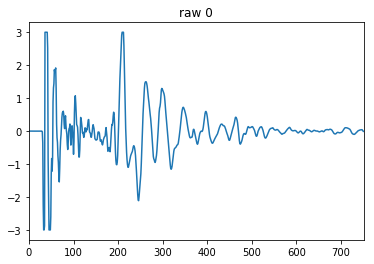

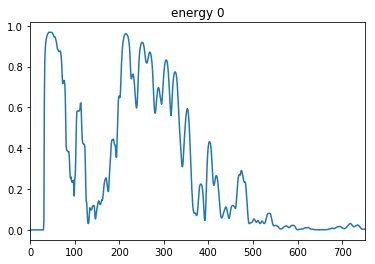

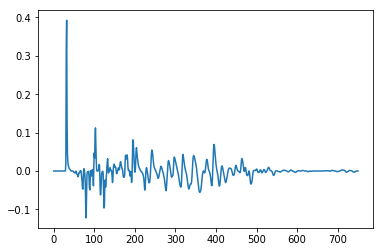

In [39]:
batch.seismic_plot('raw', index=0)
batch.seismic_plot('energy', index=0)
plt.figure()
plt.plot(np.gradient(batch.energy[0]))

## Model evaluation

In [ ]:
pipeline.run(batch_size=500, n_epochs=1, bar=True)

In [41]:
true = np.concatenate(pipeline.get_variable('true')) / 2
pred = np.concatenate(pipeline.get_variable('predictions'))
raw = np.concatenate(pipeline.get_variable('raw'))
energy = np.concatenate(pipeline.get_variable('raw'))

Mean absolute error

In [13]:
np.mean(np.abs(true-pred))

array([6.645794])

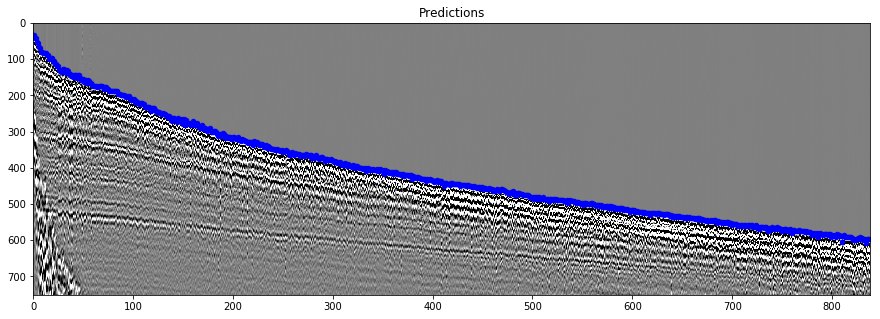

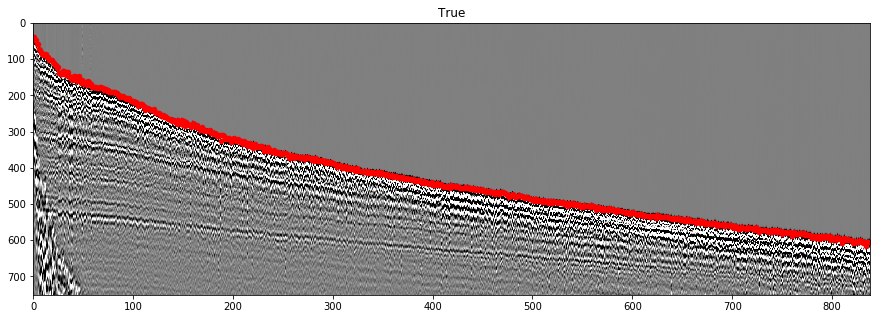

In [44]:
cv = 1
pts=(range(len(pred)), pred)
seismic_plot(np.concatenate(raw), cmap='gray', vmin=-cv, vmax=cv, pts=pts, s=20, c='b', figsize=(15,5), names=['Predictions'])
pts=(range(len(true)), true)
seismic_plot(np.concatenate(raw), cmap='gray', vmin=-cv, vmax=cv, pts=pts, s=20, c='r', figsize=(15,5), names=['True'])

Take a closer look. Ten first traces of the field.

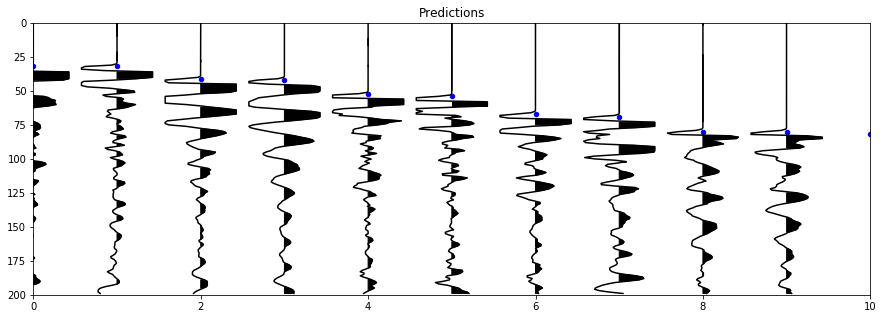

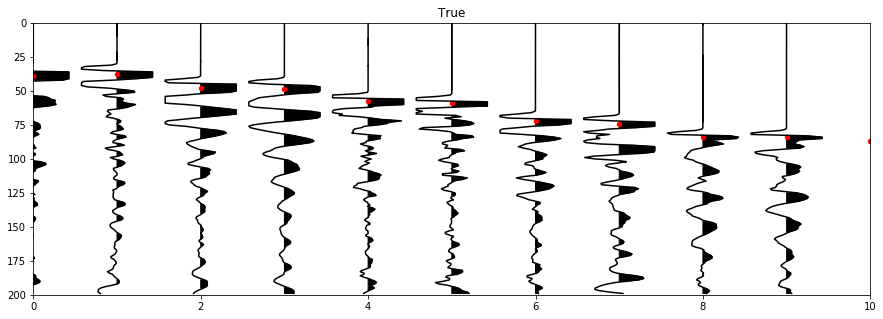

In [46]:
cv = 1
xlim = (0, 10)
ylim = (0, 200)
std = 0.1
pts=(range(len(pred)), pred)
seismic_plot(np.concatenate(raw), cmap='gray', vmin=-cv, vmax=cv, pts=pts, s=20, c='b', figsize=(15,5), names=['Predictions'],
            xlim=xlim, ylim=ylim, wiggle=True, std=std)
pts=(range(len(true)), true)
seismic_plot(np.concatenate(raw), cmap='gray', vmin=-cv, vmax=cv, pts=pts, s=20, c='r', figsize=(15,5), names=['True'],
            xlim=xlim, ylim=ylim, wiggle=True, std=std)